<a href="https://colab.research.google.com/github/tarek909/SwinTransfrmer-For-FaceshapeClassification/blob/main/Face_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install datasets
from datasets import load_dataset



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 5.6 MB/s 
     |████████████████████████████████| 115 kB 74.0 MB/s 
     |████████████████████████████████| 163 kB 73.3 MB/s 
     |████████████████████████████████| 212 kB 60.7 MB/s 
     |████████████████████████████████| 95 kB 6.1 MB/s 
     |████████████████████████████████| 127 kB 53.8 MB/s 
     |████████████████████████████████| 115 kB 58.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os


Mounted at /content/drive


In [3]:
# os.environ['KAGGLE_USERNAME'] = "" # username from the json file
# os.environ['KAGGLE_KEY'] = ""
# !kaggle datasets download -d niten19/face-shape-dataset


In [4]:
! unzip "/content/drive/MyDrive/Assignments/FaceShape Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: FaceShape Dataset/testing_set/Oval/oval (516).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (517).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (518).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (519).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (520).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (521).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (523).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (524).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (525).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (526).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (527).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (528).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (531).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (549).jpg  
  inflating: FaceShape Dataset/testing_

In [5]:
train_ds = load_dataset("imagefolder", data_dir='/content/FaceShape Dataset/training_set', split="train")
test_ds = load_dataset("imagefolder", data_dir='/content/FaceShape Dataset/testing_set', split="train")
# label2idx and idx2label

id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
# split train, val
splits = train_ds.train_test_split(test_size=0.05, shuffle=True, seed=42)
train_ds, val_ds = splits["train"], splits["test"]
print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
print("Test", test_ds)
print("Num labels", len(label2id))
print("Label2Idx", label2id)
print("Label2Idx", id2label)


Resolving data files:   0%|          | 0/4502 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-65b37f05adb6f237/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-30abc09ee5dc7f66/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Features {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['Heart', 'Oblong', 'Oval', 'Round', 'Square'], id=None)}
Train Dataset({
    features: ['image', 'label'],
    num_rows: 4275
})
Validation Dataset({
    features: ['image', 'label'],
    num_rows: 225
})
Test Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})
Num labels 5
Label2Idx {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}
Label2Idx {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}


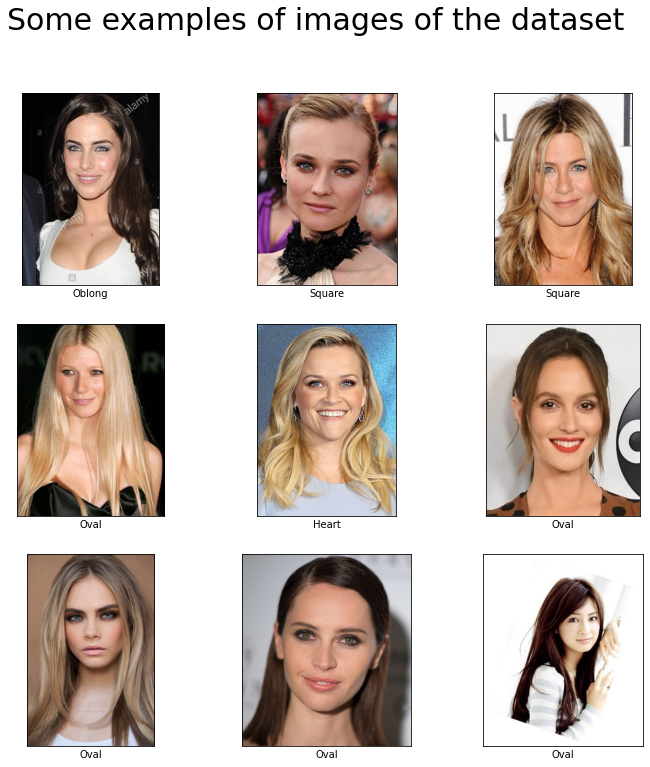

In [6]:
import cv2
import matplotlib.pyplot as plt  
from random import randint
list_idx = [randint(0, len(train_ds)) for i in range(9)]
def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the dataset", fontsize=30)
    for i, idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel(id2label[train_ds[idx]["label"]])
    plt.show()

display_examples()

In [7]:
!pip install transformers
from transformers import AutoFeatureExtractor
import torchvision.transforms.functional

from torchvision.transforms import (
    CenterCrop, 
    Compose, 
    Normalize, 
    RandomHorizontalFlip,
    RandomResizedCrop, 
    Resize, 
    RandomAdjustSharpness,
    ToTensor
    
)

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            # RandomAdjustSharpness(2, 0.8),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            # RandomAdjustSharpness(2, p=0.8),

            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 51.9 MB/s 


Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

In [8]:
feature_extractor.image_mean, feature_extractor.image_std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [9]:
print(train_transforms)

<function train_transforms at 0x7f8369f5e290>


In [10]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=64)

In [11]:
from transformers import SwinForImageClassification, SwinConfig

config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True
)

Downloading:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [13]:
from transformers import TrainingArguments, Trainer
metric_name = "accuracy"
args = TrainingArguments(
    f"faceshape",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=4e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=30,
    weight_decay=0.01,
    load_best_model_at_end=False,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [14]:
from datasets import load_metric
import numpy as np

metric = load_metric(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


In [15]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [16]:
torch.cuda.empty_cache()
import gc
gc.collect()


2718

In [17]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4275
  Num Epochs = 30
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2010
  Number of trainable parameters = 27523199


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.769877,0.191111
2,No log,1.560687,0.315556
3,No log,1.571934,0.320000
4,No log,1.601288,0.333333
5,No log,1.349658,0.422222
6,No log,1.436430,0.404444
7,No log,1.312188,0.404444
8,1.468000,1.202096,0.475556
9,1.468000,1.034471,0.600000
10,1.468000,1.070533,0.586667


***** Running Evaluation *****
  Num examples = 225
  Batch size = 64
Saving model checkpoint to faceshape/checkpoint-67
Configuration saved in faceshape/checkpoint-67/config.json
Model weights saved in faceshape/checkpoint-67/pytorch_model.bin
Feature extractor saved in faceshape/checkpoint-67/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 225
  Batch size = 64
Saving model checkpoint to faceshape/checkpoint-134
Configuration saved in faceshape/checkpoint-134/config.json
Model weights saved in faceshape/checkpoint-134/pytorch_model.bin
Feature extractor saved in faceshape/checkpoint-134/preprocessor_config.json
Deleting older checkpoint [faceshape/checkpoint-67] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 225
  Batch size = 64
Saving model checkpoint to faceshape/checkpoint-201
Configuration saved in faceshape/checkpoint-201/config.json
Model weights saved in faceshape/checkpoint-201/pytorch_model.bin
Feature extractor saved i

TrainOutput(global_step=2010, training_loss=0.9368542203855752, metrics={'train_runtime': 3417.2108, 'train_samples_per_second': 37.531, 'train_steps_per_second': 0.588, 'total_flos': 3.188047810235904e+18, 'train_loss': 0.9368542203855752, 'epoch': 30.0})

In [27]:
PATH = "entire_model_final.pt"

# Save
torch.save(model, PATH)


In [19]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 225
  Batch size = 64


{'eval_loss': 0.6013256311416626,
 'eval_accuracy': 0.8444444444444444,
 'eval_runtime': 4.4374,
 'eval_samples_per_second': 50.705,
 'eval_steps_per_second': 0.901,
 'epoch': 30.0}

In [20]:

outputs = trainer.predict(test_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names

***** Running Prediction *****
  Num examples = 1000
  Batch size = 64


{'test_loss': 0.5343746542930603, 'test_accuracy': 0.841, 'test_runtime': 20.3708, 'test_samples_per_second': 49.09, 'test_steps_per_second': 0.785}


In [24]:

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Heart       0.82      0.83      0.83       200
      Oblong       0.86      0.92      0.88       200
        Oval       0.79      0.76      0.77       200
       Round       0.86      0.81      0.84       200
      Square       0.88      0.89      0.88       200

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



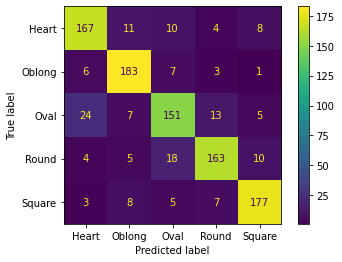

In [25]:

# Confusion matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [29]:
import shutil
shutil.copy("/content/entire_model_final.pt","/content/drive/MyDrive/Assignments")


'/content/drive/MyDrive/Assignments/entire_model_final.pt'

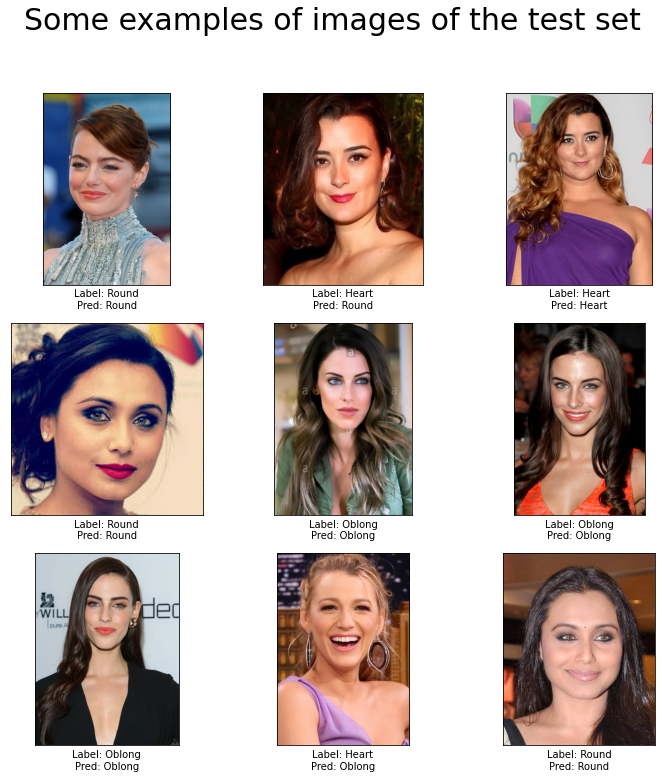

In [30]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(9)]

def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the test set", fontsize=30)
    for i,idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel("Label: "+id2label[y_true[idx]]+"\nPred: "+id2label[y_pred[idx]])
    plt.show()

display_examples()